# The influence of healthcare spending on life expectancy
## An essay by Frank Kloosterman & Jochem Vlug
Studentnumbers: 4373863 & 4165993

![Healthcare](http://northcentralhealthdistrict.org/wp-content/uploads/2017/07/Coalition-banner.jpg)

## Introduction

In this report, a data analysis has been conducted on healthcare around the world. Using data from three datasets, we try to answer our research question:

*"What is the relation between life expectancy and healthcare spending?"*

This research question has two sub questions:
- Is there a relation between healthcare spending by government and life expectancy?
- Is there a relation between personal healthcare spending and life expactancy?
- Is there a relation between GDP and personal healthcare spending?


## Packages

To be able read the datasets, apply mathematical operations to the data, plot graphs and execute many more operations we use libraries made by the community using packages. First, we import these packages using the block below. It is necessary to run this script for the functions to work.

In [2]:
import pandas as pd # Pandas, needed for data frames.
import numpy as np # NumPy, for math operations and arrays.
import matplotlib.pyplot as plt #matplotlib, for making plots.
import missingno as msno # Missingno, a usefull library for checking missing values.
import pdb # Pythondebugger, native debugger of python.
%matplotlib inline
# A line which causes plots to  make graphs directly below codeblocks after running them.

## Datasets
The data used for our research consists of three datasets, which are loaded in the block below. These datasets are:
- Sustainable Development Goals, The World Bank. 2017. datacatalog.worldbank.org
- Life Expectancy, Global Health Observatory - World Health Organisation (WHO). 2017. who.int/gho
- Average Household Pocket Money, The World Bank. 2017. data.worldbank.org
- Capital Health Expenditure, Global Health Observatory - World Health Organisation (WHO). 2017. who.int/gho

In [3]:
# Sustainable Development Goals
SDG = pd.read_csv("https://github.com/Jochem285/EPA1333FA/raw/master/Data/SustainableDevelopmentGoals.csv")
# Life Expectancy
life_exp = pd.read_csv("https://github.com/Jochem285/EPA1333FA/raw/master/Data/LifeExpectancy.csv")
# Household pocket money. Second row is empty, so we skip it.
house_money = pd.read_excel("https://github.com/Jochem285/EPA1333FA/raw/master/Data/HouseholdPocketMoney.xlsx",skiprows=[1],index_col=0)
# Capital health expenditure. Second row is empty, so we skip it.
cap_exp = pd.read_excel("https://github.com/Jochem285/EPA1333FA/raw/master/Data/CapitalHealthExpenditure.xlsx",skiprows=[1],index_col=0)

## Search the Data
To get a rough overview of the data, we first make a function which can search the data using a keyword to search for. 

In [4]:
#Search world_bank database for keyphrase
def searchData(myInput):
    variableList = []
    for sentence in list(SDG["Indicator Name"].values):
        newSentence = np.array(sentence.split(" "))
        for words in (newSentence):
            if words.lower() == myInput.lower(): 
                variableList += [sentence]

    variableList = pd.unique(variableList)
    return variableList
searchData("") #insert search input here.
                                


array(['Women making their own informed decisions regarding sexual relations, contraceptive use and reproductive health care  (% of women age 15-49)'],
      dtype=object)

## Overview of the Data
To get an overview of the data and the availability of data in the datasets, we plot a matrix which shows the amount of (missing) data. We use MissingNo to make this matrix.

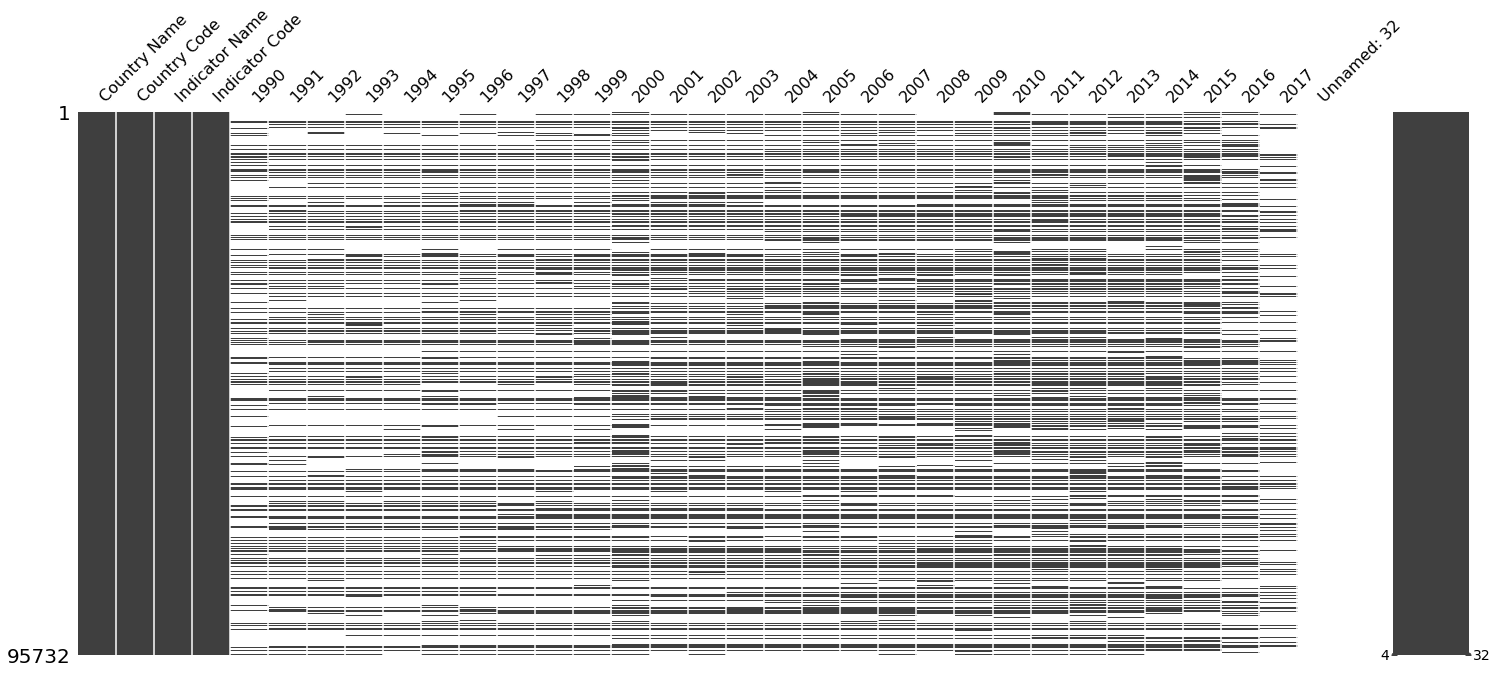

In [5]:
#First summarise status of data by making a NaN matrix.
msno.matrix(SDG.sample(len(SDG)))
#life_exp["Life "] = life_exp["Life Expectancy"] TODO fix colomn name
#msno.matrix(life_exp.sample(len(life_exp)))
#msno.matrix(house_money.sample(len(house_money)))
#msno.matrix(cap_exp.sample(len(cap_exp)))


## Transforming the Data

In [6]:
#This section makes a Top 20 list of richest and poorest countries based on GDP per capita, PPP.
#We will use these countries in further analysis

#Define the countries and their GDP's to determine Top richest and poorest.
countries = SDG[SDG["Indicator Name"]== 'GDP per capita, PPP (constant 2011 international $)']["Country Name"]
GDP_2016 = SDG[SDG["Indicator Name"]== 'GDP per capita, PPP (constant 2011 international $)']["2016"]
GDP_2017 = SDG[SDG["Indicator Name"]== 'GDP per capita, PPP (constant 2011 international $)']["2017"]

#Combine the country names with GDP's
GDP_1617 = countries.to_frame().join(GDP_2017.to_frame()).join(GDP_2016.to_frame())
    
#Mask the entries in the top 20's of the list which are actually not countries.
GDP_1617 = GDP_1617.mask(GDP_1617["Country Name"]=="Macao SAR, China")
GDP_1617 = GDP_1617.mask(GDP_1617["Country Name"]=="Hong Kong SAR, China")
GDP_1617 = GDP_1617.mask(GDP_1617["Country Name"]=="North America")
#Masked San Marino as well, since almost no data available
GDP_1617 = GDP_1617.mask(GDP_1617["Country Name"]=="San Marino")

#Define the top20's
lowest_20 = GDP_1617.sort_values("2017")[0:20]
highest_20 = GDP_1617.sort_values("2017", ascending=False)[0:20]

lowest_countries = lowest_20["Country Name"]
highest_countries = highest_20["Country Name"]
    
#Concate the highest and lowest together.
newCountries = pd.concat([lowest_countries, highest_countries])
#Changes the country names to match other database.
newCountries = newCountries.sort_values(ascending = True)

if len(newCountries) < 40:
    newCountries = str("Something went wrong.")
else:
    newCountries = list(newCountries.values)

In [15]:
#Match the countries of the SDG dataset with the countries of the Household_ppp dataset
household_countries = newCountries
household_countries[10]="DRC"
household_countries[13]="Gambia"
household_countries[39]="United States of America"

household_data = house_money.loc[household_countries]
household_data = household_data.drop(["Indicators",'Unnamed: 2'], axis = 1).T

D:\Python\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys


In [9]:
#Match the countries of the SDG dataset with the countries of the life expectancy dataset
life_exp_countries = newCountries
life_exp_countries[4]="Brunei"
life_exp_countries[11] = "Congo"
life_exp_countries[14] = "Gambia"

life_exp_data = life_exp.loc[life_exp["Entity"].isin(life_exp_countries)]


In [10]:
#Transform the life expectancy data into the same format as household data
#Create the dataframe by starting with the first
LE_total = pd.DataFrame()
for Country in life_exp_data["Entity"].unique():
    LE_country = life_exp_data[life_exp_data["Entity"]==Country]
    years = LE_country["Year"].values
    LE_country = LE_country.set_index(years)
    LE_country = LE_country.iloc[:,3:]
    LE_country.columns = [Country]
    if LE_total.empty:
        LE_total = LE_country
    else: 
        LE_total = pd.merge(LE_total, LE_country, left_index=True, right_index=True)    

In [13]:
#Rename to earlier variable with the same years as in household dataset
life_exp_data = LE_total[50:]
#life_exp_data

,Afghanistan,Australia,Austria,Bahrain,Brunei,Burkina Faso,Burundi,Canada,Central African Republic,Chad,...,Qatar,Rwanda,Saudi Arabia,Sierra Leone,Singapore,Sweden,Switzerland,Togo,Uganda,United Arab Emirates
2000,55.481998,79.589996,78.238998,74.440002,75.202003,50.488998,51.544998,79.113998,43.937000,47.592999,...,76.278999,48.415001,72.440002,38.702000,78.338997,79.724998,79.858002,53.488998,47.077000,74.238998
2001,56.043999,79.885002,78.517998,74.635002,75.425003,50.893002,51.778999,79.337997,43.755001,47.603001,...,76.387001,49.792999,72.651001,39.660000,78.664001,79.893997,80.117996,53.550999,48.119999,74.487000
2002,56.637001,80.175003,78.791000,74.821999,75.650002,51.383999,51.977001,79.565002,43.717999,47.638000,...,76.487999,50.970001,72.820000,40.660000,79.028999,80.061996,80.377998,53.707001,49.242001,74.730003
2003,57.250000,80.452003,79.058998,74.999001,75.875000,51.956001,52.189999,79.791000,43.827000,47.716000,...,76.581001,52.268002,72.947998,41.668999,79.419998,80.235001,80.640999,53.935001,50.394001,74.968002
2004,57.875000,80.712997,79.318001,75.167000,76.093002,52.602001,52.437000,80.013000,44.080002,47.848000,...,76.667999,53.755001,73.041000,42.660000,79.824997,80.413002,80.903999,54.230000,51.537998,75.199997
2005,58.500000,80.955002,79.566002,75.325996,76.291000,53.310001,52.735001,80.232002,44.466000,48.054001,...,76.753998,55.430000,73.112000,43.624001,80.230003,80.596001,81.163002,54.598000,52.639999,75.421997
2006,59.110001,81.175003,79.799004,75.477997,76.455002,54.063000,53.090000,80.446999,44.966999,48.348999,...,76.843002,57.219002,73.176003,44.566002,80.619003,80.780998,81.413002,55.048000,53.681000,75.632004
2007,59.694000,81.376999,80.015999,75.625000,76.577003,54.841000,53.492001,80.658997,45.551998,48.729000,...,76.940002,58.971001,73.245003,45.500000,80.982002,80.963997,81.650002,55.577999,54.660000,75.828003
2008,60.243000,81.565002,80.218002,75.769997,76.655998,55.618000,53.925999,80.870003,46.189999,49.181999,...,77.049004,60.564999,73.331001,46.431999,81.311996,81.142998,81.872002,56.174000,55.574001,76.012001
2009,60.754002,81.741997,80.406998,75.913002,76.698997,56.375999,54.386002,81.079002,46.862000,49.691002,...,77.168999,61.962002,73.440002,47.348000,81.602997,81.317001,82.078003,56.813999,56.409000,76.182999


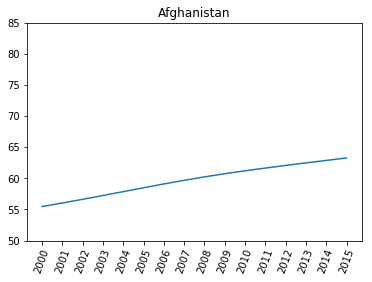

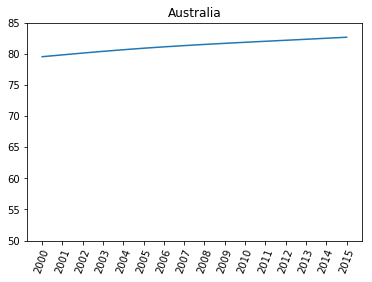

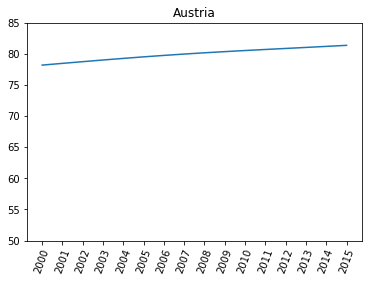

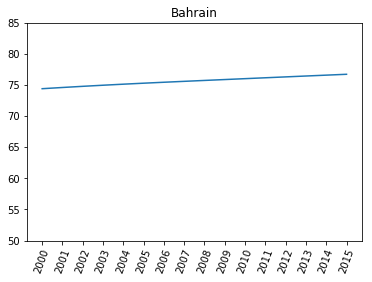

KeyError: 'Brunei'

In [12]:
#Plot all countries to discover behaviour. 
for Country in life_exp_data.columns:
    Country_LE = life_exp_data[Country]
    Country_HH = household_data[Country]
    plt.plot(household_data.index, Country_LE)
    plt.title(Country)
    plt.xticks(rotation = 70)
    plt.yticks(np.arange(50,90,5))
    plt.show()